# Proyek Klasifikasi Gambar: [Fruits 360]
- **Nama:** [Naufal Helmy Mustofa]
- **Email:** [chiefhelmy01@gmail.com]
- **ID Dicoding:** [B25B8M098]

## Import Semua Packages/Library yang Digunakan

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import shutil
import random
import tensorflowjs as tfjs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.model_selection import train_test_split

## Data Preparation

### Data Loading

In [4]:
!kaggle datasets download -d moltean/fruits -p ./fruit_360
!unzip -q ./fruit_360/fruits.zip -d ./fruit_360

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 4.35G/4.36G [01:01<00:00, 81.7MB/s]
100% 4.36G/4.36G [01:01<00:00, 75.8MB/s]


### Data Preprocessing

#### Split Dataset

In [5]:
base_dir = "/content/fruit_360/fruits-360_100x100/fruits-360"
print(sorted(os.listdir(base_dir)))

['LICENSE', 'README.md', 'Test', 'Training']


In [6]:
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Test")

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode="categorical"
)

class_indices = train_generator.class_indices
print("Kelas:", class_indices)
print("Jumlah kelas:", len(class_indices))

Found 114482 images belonging to 221 classes.
Found 38183 images belonging to 221 classes.
Kelas: {'Apple 10': 0, 'Apple 11': 1, 'Apple 12': 2, 'Apple 13': 3, 'Apple 14': 4, 'Apple 17': 5, 'Apple 18': 6, 'Apple 19': 7, 'Apple 5': 8, 'Apple 6': 9, 'Apple 7': 10, 'Apple 8': 11, 'Apple 9': 12, 'Apple Braeburn 1': 13, 'Apple Core 1': 14, 'Apple Crimson Snow 1': 15, 'Apple Golden 1': 16, 'Apple Golden 2': 17, 'Apple Golden 3': 18, 'Apple Granny Smith 1': 19, 'Apple Pink Lady 1': 20, 'Apple Red 1': 21, 'Apple Red 2': 22, 'Apple Red 3': 23, 'Apple Red Delicious 1': 24, 'Apple Red Yellow 1': 25, 'Apple Red Yellow 2': 26, 'Apple Rotten 1': 27, 'Apple hit 1': 28, 'Apple worm 1': 29, 'Apricot 1': 30, 'Avocado 1': 31, 'Avocado Black 1': 32, 'Avocado Green 1': 33, 'Avocado ripe 1': 34, 'Banana 1': 35, 'Banana 3': 36, 'Banana 4': 37, 'Banana Lady Finger 1': 38, 'Banana Red 1': 39, 'Beans 1': 40, 'Beetroot 1': 41, 'Blackberrie 1': 42, 'Blackberrie 2': 43, 'Blackberrie half rippen 1': 44, 'Blackberrie

In [8]:
combined_dir = os.path.join(base_dir, "combined_data")
os.makedirs(combined_dir, exist_ok=True)

for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

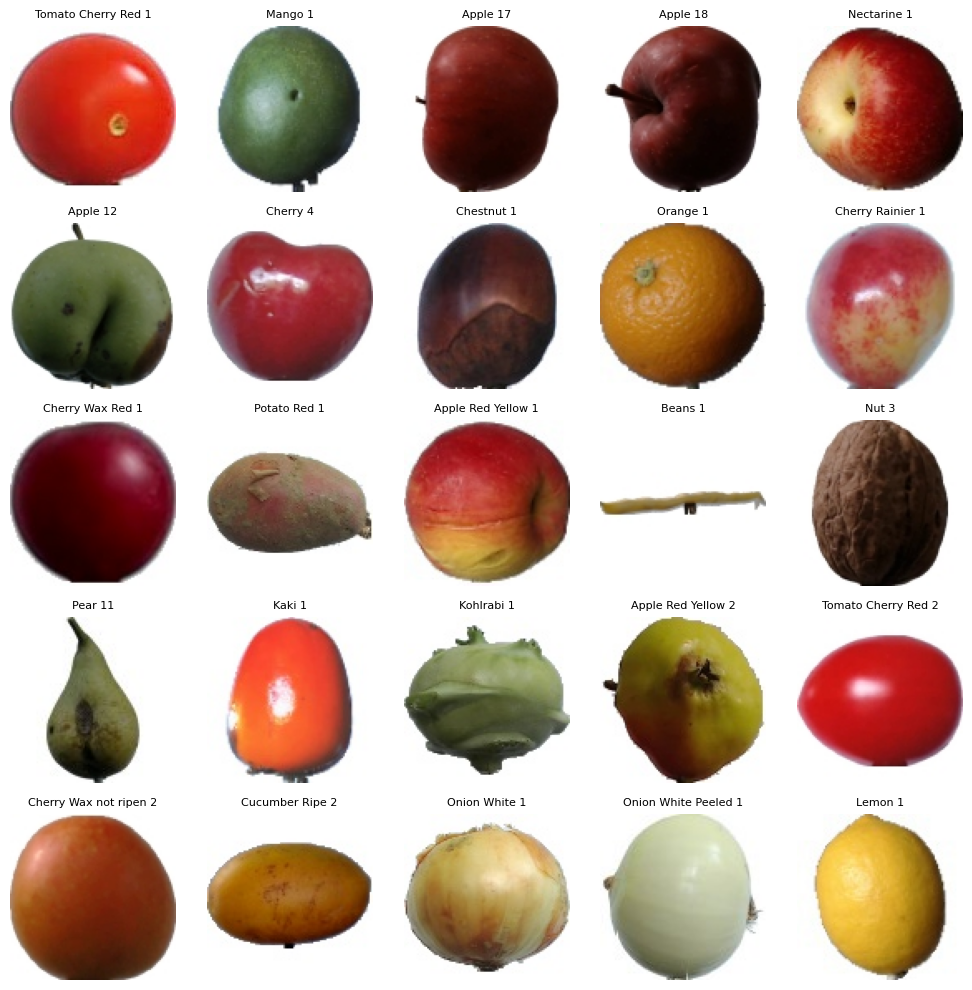

In [9]:
def show_sample_images(generator, class_names, n_classes=25):
    plt.figure(figsize=(10, 10))
    chosen_classes = random.sample(class_names, min(n_classes, len(class_names)))
    img_paths = []
    labels = []
    for cls in chosen_classes:
        class_dir = os.path.join(train_dir, cls)
        img_file = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, img_file)
        img_paths.append(img_path)
        labels.append(cls)
    for i, (img_path, label) in enumerate(zip(img_paths, labels)):
        plt.subplot(5, 5, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(label, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

class_names = list(train_generator.class_indices.keys())
show_sample_images(train_generator, class_names)

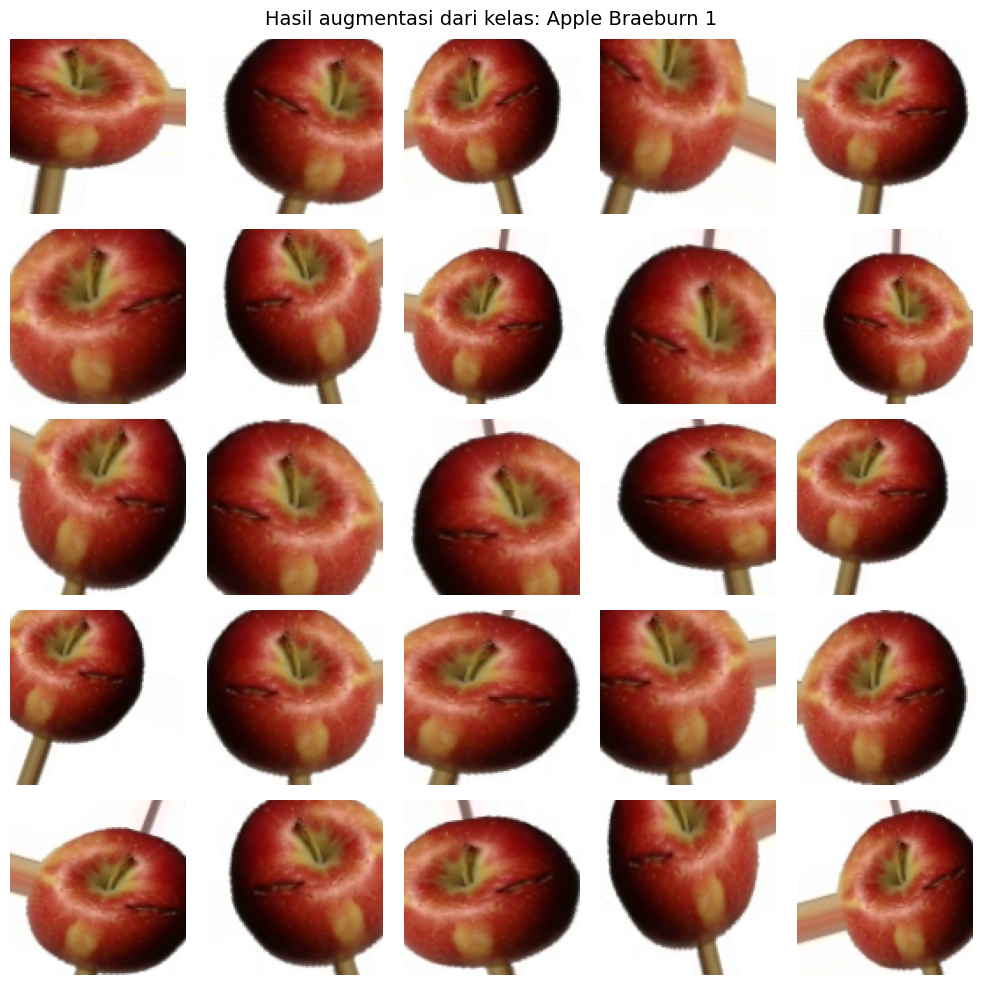

In [10]:
def show_augmented_images(generator, class_name, n_images=25):
    class_dir = os.path.join(train_dir, class_name)
    img_file = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_file)
    img = Image.open(img_path).convert("RGB")
    img = img.resize((100, 100))
    img_array = np.expand_dims(np.array(img), axis=0)
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Hasil augmentasi dari kelas: {class_name}", fontsize=14)
    aug_iter = generator.flow(img_array, batch_size=1)
    for i in range(n_images):
        plt.subplot(5, 5, i + 1)
        augmented_img = next(aug_iter)[0]
        augmented_img = np.clip(augmented_img, 0, 1)
        plt.imshow(augmented_img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

random_class = random.choice(class_names)
show_augmented_images(train_datagen, random_class)

In [11]:
new_train_dir = "path/to/new_train"
new_test_dir = "path/to/new_test"

os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in os.listdir(test_dir)}
total_counts = {cls: train_counts.get(cls, 0) + test_counts.get(cls, 0) for cls in train_counts}

sorted_classes = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)
top_classes = [cls for cls, count in sorted_classes[:10]]

print("10 kelas dengan jumlah data terbanyak:")
for cls in top_classes:
    print(f"{cls}: {total_counts[cls]} (train={train_counts[cls]}, test={test_counts[cls]})")
for cls in top_classes:
    os.makedirs(os.path.join(new_train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(new_test_dir, cls), exist_ok=True)
    for file in os.listdir(os.path.join(train_dir, cls)):
        src = os.path.join(train_dir, cls, file)
        dst = os.path.join(new_train_dir, cls, file)
        shutil.copy(src, dst)
    for file in os.listdir(os.path.join(test_dir, cls)):
        src = os.path.join(test_dir, cls, file)
        dst = os.path.join(new_test_dir, cls, file)
        shutil.copy(src, dst)

train_total_new = sum(len(os.listdir(os.path.join(new_train_dir, cls))) for cls in top_classes)
test_total_new = sum(len(os.listdir(os.path.join(new_test_dir, cls))) for cls in top_classes)
total_new = train_total_new + test_total_new
print("\n")
print(f"Total data train: {train_total_new}")
print(f"Total data test : {test_total_new}")
print(f"Total seluruh gambar: {total_new}")

10 kelas dengan jumlah data terbanyak:
Grape Blue 1: 1312 (train=984, test=328)
Cherimoya 1: 1292 (train=972, test=320)
Pear 9: 1236 (train=928, test=308)
Peach 3: 1233 (train=927, test=306)
Plum 3: 1204 (train=900, test=304)
Onion 2: 1020 (train=765, test=255)
Quince 4: 999 (train=750, test=249)
Cherry Rainier 1: 984 (train=738, test=246)
Tomato 3: 984 (train=738, test=246)
Tomato 1: 984 (train=738, test=246)


Total data train: 8440
Total data test : 2808
Total seluruh gambar: 11248


10 kelas yang digunakan: ['Cherimoya 1', 'Cherry Rainier 1', 'Grape Blue 1', 'Onion 2', 'Peach 3', 'Pear 9', 'Plum 3', 'Quince 4', 'Tomato 1', 'Tomato 3']


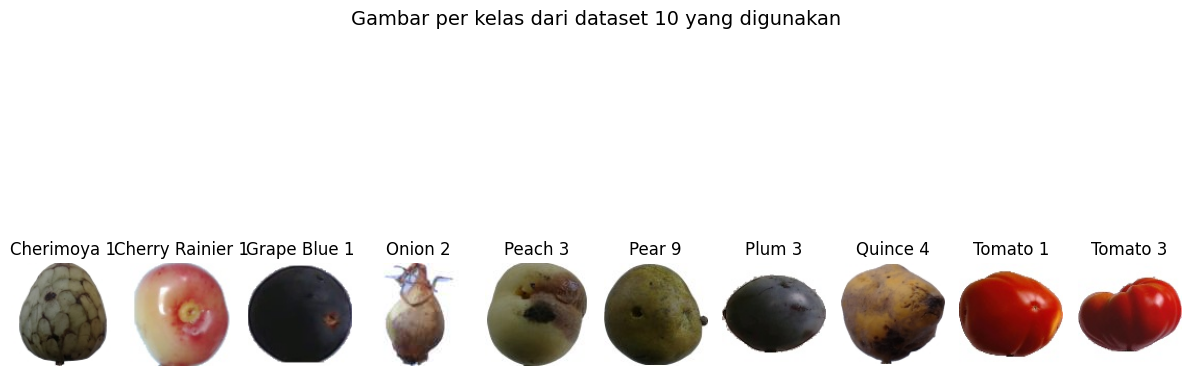

In [12]:
selected_classes = sorted(os.listdir(new_train_dir))
print("10 kelas yang digunakan:", selected_classes)

plt.figure(figsize=(12, 6))
for i, cls in enumerate(selected_classes):
    cls_dir = os.path.join(new_train_dir, cls)
    img_file = random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, img_file)
    img = Image.open(img_path)
    plt.subplot(1, len(selected_classes), i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.suptitle("Gambar per kelas dari dataset 10 yang digunakan", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
new_train_final_dir = "path/to/final_train"
new_val_dir = "path/to/final_val"
new_test_final_dir = "path/to/final_test"

os.makedirs(new_train_final_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)
os.makedirs(new_test_final_dir, exist_ok=True)

X = []
y = []

for cls in os.listdir(new_train_dir):
    class_dir = os.path.join(new_train_dir, cls)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                X.append(os.path.join(class_dir, file))
                y.append(cls)

X = np.array(X)
y = np.array(y)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Jumlah data training    : {len(X_train_split)}")
print(f"Jumlah data validation  : {len(X_val_split)}")

import shutil

for folder in [new_train_final_dir, new_val_dir, new_test_final_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

def copy_files(X, y, target_dir):
    for path, label in zip(X, y):
        class_dir = os.path.join(target_dir, label)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(path, class_dir)

copy_files(X_train_split, y_train_split, new_train_final_dir)
copy_files(X_val_split, y_val_split, new_val_dir)

for cls in os.listdir(new_test_dir):
    src_class = os.path.join(new_test_dir, cls)
    dst_class = os.path.join(new_test_final_dir, cls)
    os.makedirs(dst_class, exist_ok=True)
    for file in os.listdir(src_class):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            shutil.copy(os.path.join(src_class, file), dst_class)

Jumlah data training    : 6752
Jumlah data validation  : 1688


## Modelling

In [14]:
train_dir = "path/to/final_train"
val_dir = "path/to/final_val"
test_dir = "path/to/final_test"

img_size = (100, 100)

def load_images_from_folder(folder):
    images = []
    labels = []
    for cls in os.listdir(folder):
        class_dir = os.path.join(folder, cls)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(class_dir, file)
                    img = image.load_img(img_path, target_size=img_size)
                    img_array = image.img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(cls)
    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_folder(train_dir)
X_val, y_val = load_images_from_folder(val_dir)
X_test, y_test = load_images_from_folder(test_dir)

label_encoder = LabelEncoder()
y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
y_val_enc = to_categorical(label_encoder.transform(y_val))
y_test_enc = to_categorical(label_encoder.transform(y_test))

num_classes = len(label_encoder.classes_)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_size[0], img_size[1], 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

early_stopping = callbacks.EarlyStopping(patience=3)
history = model.fit(
    X_train, y_train_enc,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_enc),
    callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(X_test, y_test_enc)
print(f"Akurasi data test: {test_acc:.4f}")
print(f"Loss data test   : {test_loss:.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,066 (6.61 MB)

 Trainable params: 1,733,066 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 146s 678ms/step - accuracy: 0.6835 - loss: 0.9055 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 209s 713ms/step - accuracy: 0.9819 - loss: 0.0578 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 141s 668ms/step - accuracy: 0.9820 - loss: 0.0530 - val_accuracy: 1.0000 - val_loss: 1.0847e-04
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 148s 697ms/step - accuracy: 0.9955 - loss: 0.0127 - val_accuracy: 0.9994 - val_loss: 0.0018
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 199s 685ms/step - accuracy: 0.9951 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 3.7644e-04
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 146s 690ms/step - accuracy: 0.9805 - loss: 0.0571 - val_accuracy: 0.9994 - val_loss: 0.0018
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.9995 - loss: 0.0011
Akurasi data test: 0.9993
Loss data test   : 0.0017


## Evaluasi dan Visualisasi

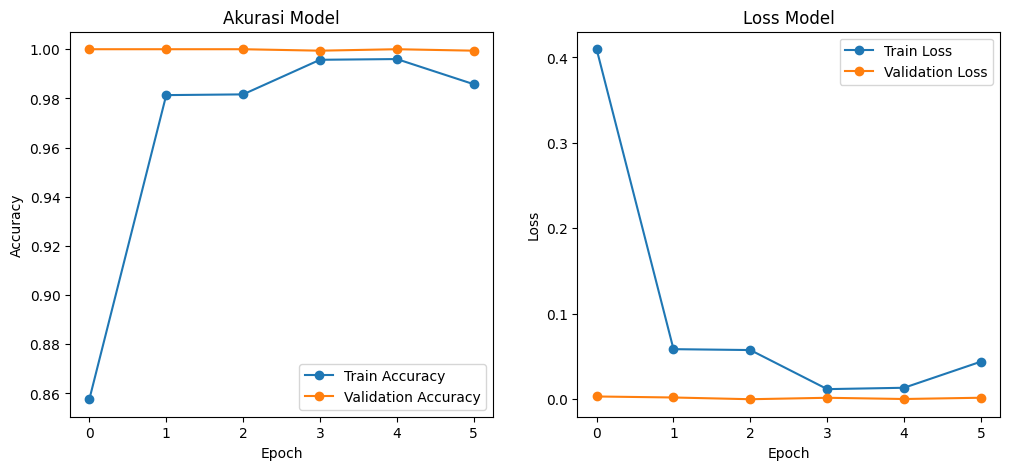

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", marker="o")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker="o")
plt.title("Akurasi Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", marker="o")
plt.plot(history.history["val_loss"], label="Validation Loss", marker="o")
plt.title("Loss Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Konversi Model

In [30]:
base_dir = "submission"
tfjs_dir = os.path.join(base_dir, "tfjs_model")
tflite_dir = os.path.join(base_dir, "tflite")
saved_model_dir = os.path.join(base_dir, "saved_model")

os.makedirs(tfjs_dir, exist_ok=True)
os.makedirs(tflite_dir, exist_ok=True)
os.makedirs(saved_model_dir, exist_ok=True)
saved_model_dir = "submission/saved_model"
os.makedirs(saved_model_dir, exist_ok=True)
model.export(saved_model_dir)

!mkdir -p submission/tfjs_model
!tensorflowjs_converter --input_format=tf_saved_model \
  --output_node_names='dense_1' \
  --saved_model_tags=serve \
  submission/saved_model submission/tfjs_model

tflite_model_dir = "submission/tflite"
os.makedirs(tflite_model_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(f"{tflite_model_dir}/model.tflite", "wb") as f:
    f.write(tflite_model)

with open(f"{tflite_model_dir}/label.txt", "w") as f:
    for label in label_encoder.classes_:
        f.write(label + "\n")

!zip -r submission.zip submission
from google.colab import files
files.download("submission.zip")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137103683228240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683236304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683232080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683234768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683233424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683232272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683227664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683233616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683232464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137103683231120: TensorSpec(shape=(), dtype=tf.resource, name=None)
2025-10-0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Gambar: path/to/final_test/Peach 3/r0_91_100.jpg
Kelas sebenarnya: Peach 3
Kelas prediksi  : Peach 3


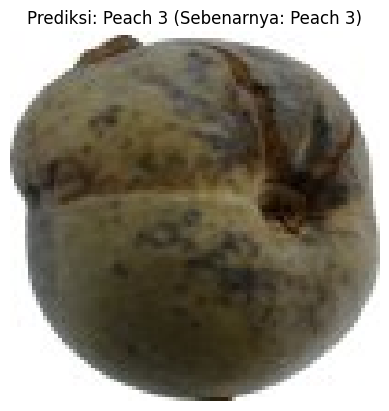

In [31]:
def predict_image(model, img_path, label_encoder, img_size=(100, 100)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = label_encoder.classes_[predicted_class_index]
    return predicted_class

random_class_test = random.choice(os.listdir(test_dir))
random_img_file = random.choice(os.listdir(os.path.join(test_dir, random_class_test)))
random_img_path = os.path.join(test_dir, random_class_test, random_img_file)

predicted_class = predict_image(model, random_img_path, label_encoder)

print(f"Gambar: {random_img_path}")
print(f"Kelas sebenarnya: {random_class_test}")
print(f"Kelas prediksi  : {predicted_class}")

img = Image.open(random_img_path)
plt.imshow(img)
plt.title(f"Prediksi: {predicted_class} (Sebenarnya: {random_class_test})")
plt.axis("off")
plt.show()